In [1]:
import numpy as np, pandas as pd, scipy, matplotlib.pyplot as plt, seaborn as sns, nltk, re
from nltk.corpus import gutenberg
from sklearn.model_selection import train_test_split

%matplotlib inline

nltk.download('punkt')
nltk.download('gutenberg')

# Read the data as paragraphs
emma = gutenberg.paras('austen-emma.txt')

# Processing
emma_paras = []
for paragraph in emma:
    para=paragraph[0]
    
    # Remove double dash
    para=[re.sub(r'--', '', word) for word in para]
    
    # Format to string and add to list
    emma_paras.append(' '.join(para))

print(emma_paras[:4])

[nltk_data] Downloading package punkt to /Users/jkovach/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/jkovach/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [2]:
# Drill #1: tuning
# Tf-idf with Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than half the paragraphs
                             min_df=2, #only use words that appear at least twice
                             stop_words='english',
                             lowercase=True, #converts all words to lowercase
                             use_idf=True, #use idf as weights
                             norm=u'l1', #correction factor for document length (L1, L2, or max)
                             smooth_idf=True #Adds 1 to all doc frequencies, prevents divide by zero errors
                            )

# Apply vectorizer and split to training/test sets
emma_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_tfidf.get_shape()[1])
X_train_tfidf, X_test_tfidf = train_test_split(emma_tfidf, test_size=0.4, random_state=0)

# Reshapes output into human readable format
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Get number of paragraphs
n = X_train_tfidf_csr.shape[0]

# Create one dictionary per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# List feature words and tfidf scores for each paragraph
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
print('Original Sentence:', X_train[5])
print('TF_IDF Vector:', tfidf_bypara[5])

Number of features: 1948
Original Sentence: A very few minutes more , however , completed the present trial .
TF_IDF Vector: {'minutes': 0.5040029961941199, 'present': 0.49599700380588013}


In [3]:
# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# SVD data reducer, reducing to 130 features
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data then project
X_train_lsa = lsa.fit_transform(X_train_tfidf)

exp_var = svd.explained_variance_ratio_
total_variance = exp_var.sum()
print("Variance captured by new components: {}".format(total_variance*100))

# See what paragraphs the model considers similar
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Variance captured by new components: 63.668056008835116
Component 0
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !"    0.999928
" Oh !     0.999928
" Oh !     0.999928
Oh !       0.999928
Name: 0, dtype: float64
Component 1
" Ah !      0.999987
" Ah !      0.999987
" Ah !      0.999987
" Ah !      0.999987
" Ah !      0.999987
" Ah !      0.999987
" Ah !      0.999987
" Ah !      0.999987
" Ah !      0.999987
But ah !    0.999987
Name: 1, dtype: float64
Component 2
CHAPTER I       0.997027
CHAPTER X       0.997027
CHAPTER I       0.997027
CHAPTER I       0.997027
CHAPTER V       0.997027
CHAPTER V       0.997027
CHAPTER X       0.997027
CHAPTER V       0.997027
CHAPTER X       0.997027
CHAPTER XIII    0.992845
Name: 2, dtype: float64
Component 3
" From something that he said , my dear Emma , I rather imagine "                                                                                                   

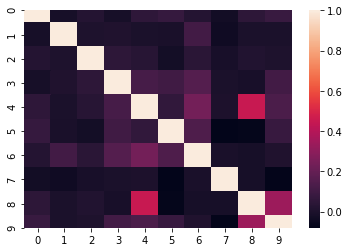

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [4]:
# Sentence Similarity
# Compute similarity between documents with LSA
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Creating a key for the plot
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

In [5]:
# Drill #0: implement with test data
X_test_tfidf_csr = X_test_tfidf.tocsr()
nt = X_test_tfidf_csr.shape[0]
tfidf_bypara = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]
    
X_test_lsa = lsa.fit_transform(X_test_tfidf)

exp_var = svd.explained_variance_ratio_
total_variance = exp_var.sum()
print("Variance captured by new components: {}".format(total_variance*100))

paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Variance captured by new components: 69.20982502178038
Component 0
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
" Oh !    0.999998
Name: 0, dtype: float64
Component 1
" Ah !     0.999629
" Ah !     0.999629
" Ah !     0.999629
" Ah !     0.999629
" Ah !     0.999629
" Ah !     0.999629
" Ah !"    0.999629
" Ah !     0.999629
" Ah !     0.999629
" Ah !     0.999629
Name: 1, dtype: float64
Component 2
" Yes I should , I am sure I should .                                                                                                                                                  0.945560
" Yes ; Jane says she is sure they will ; but yet , this is such a situation as she cannot feel herself justified in declining .                                                       0.790036
" Are you sure ?                                                                       